# BERT Fine-Tuning Quora Question pairs with PyTorch
This research is based on the toturial [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/).
# Introduction
In this research I'd like to use BERT with the huggingface PyTorch library to fine-tune a model which will perform best in question pairs classification. 

So firstly let's talk about the model and the dataset:
# Bert
Bidirectional Encoder Representations from Transformers (BERT) was released, and pretrained, in late 2018 by Google (see original model code [here](https://github.com/google-research/bert)) for NLP (Natural Language Processing) tasks. Bert was created originally by [Jacob Devlin](https://www.linkedin.com/in/jacob-devlin-135ab048) with two corpora in pre-training: BookCorpus and English Wikipedia.

BERT consists of 12 Transformer Encoding layers (or 24 for large BERT). If you stack Transformer Decoding layers you'll GPT model to generate senetances.

You can more information inthe those videos: [Transformer Neural Networks - EXPLAINED! (Attention is all you need)](https://youtu.be/TQQlZhbC5ps) [BERT Neural Network - EXPLAINED!](https://youtu.be/xI0HHN5XKDo)

# Quora Question Pairs Dataset
[Quora](https://www.quora.com/) is a question-and-answer website where questions are asked, answered, followed, and edited by Internet users, either factually or in the form of opinions. Quora was co-founded by former Facebook employees Adam D'Angelo and Charlie Cheever in June 2009. website was made available to the public for the first time on June 21, 2010. Today the website is available in many languages.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question.

The goal is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The dataset itself can be downloaded from kaggle: [here](https://www.kaggle.com/c/quora-question-pairs/).

## Data fields
* id - the id of a training set question pair
* qid1, qid2 - unique ids of each question (only available in train.csv)
* question1, question2 - the full text of each question
* is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

The set itself contains more than 400K pairs of questions.

# Fire up pandas and Read the Dataset
I'm going to read the first 5K records due to performance issue.

**Pay Attention**: in the full set there are some missing values. So before training a model the missing values should be addressed. Here I won't have any.

In [1]:
import pandas



questions_dataset = pandas.read_csv("train.csv", index_col="id", nrows=5000)
questions_dataset.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Let's see what we got:

In [2]:
questions_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   qid1          5000 non-null   int64 
 1   qid2          5000 non-null   int64 
 2   question1     5000 non-null   object
 3   question2     5000 non-null   object
 4   is_duplicate  5000 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 234.4+ KB


# Tokenizing
To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary. 

The tokenization must be performed by the tokenizer included with BERT–the below cell will download this for us. We’ll be using the “uncased” version here. This Tokenizer is build upon the WordPiece tokenizer. you can read more about it [here](https://huggingface.co/transformers/model_doc/bert.html#berttokenizerfast).

Loading BERT tokenizer:

In [3]:
from transformers import BertTokenizerFast



tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

Split a sentence into tokens:

In [4]:
print(f"Original: {questions_dataset['question1'][0]}")
print(f"Tokenized: {tokenizer.tokenize(questions_dataset['question1'][0])}")
print(f"Token IDs: {tokenizer.convert_tokens_to_ids(tokenizer.tokenize(questions_dataset['question1'][0]))}")

Original: What is the step by step guide to invest in share market in india?
Tokenized: ['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india', '?']
Token IDs: [2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1999, 2634, 1029]


We can combine ``tokenize`` and ``convert_tokens_to_ids`` with the method ``encode``:

In [5]:
print(f"Original: {questions_dataset['question2'][0]}")
print(f"Tokenized: {tokenizer.encode(questions_dataset['question2'][0])}")

Original: What is the step by step guide to invest in share market?
Tokenized: [101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102]


We can see we got two extra tokens ``101`` and ``102``. Let's see what they are:

In [6]:
tokenizer.decode([101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102])

'[CLS] what is the step by step guide to invest in share market? [SEP]'

## Special Tokens
``[SEP]`` - At the end of every sentence, we need to append the special ``[SEP]`` token.

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (remeber BERT was trained intially to perdict question-answering task).

``[CLS]`` - For classification tasks, we must prepend the special ``[CLS]`` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output.

So now let's see how to encode the two questions together:

In [7]:
encoded_pair = tokenizer.encode(questions_dataset['question1'][0], questions_dataset['question2'][0])
tokenizer.decode(encoded_pair)

'[CLS] what is the step by step guide to invest in share market in india? [SEP] what is the step by step guide to invest in share market? [SEP]'

## Sentence Length

The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:

1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.
Padding is done with a special ``[PAD]`` token, which is at index 0 in the BERT vocabulary.

The maximum length does impact training and evaluation speed.

Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.

Let's find the maximum length of question pairs:

In [8]:
from tqdm import tqdm



tqdm.pandas()
questions_dataset["question1_length"] = questions_dataset["question1"].progress_apply(lambda question: 
                                                                                      len(tokenizer.tokenize(question)))
questions_dataset["question2_length"] = questions_dataset["question2"].progress_apply(lambda question: 
                                                                                      len(tokenizer.tokenize(question)))
questions_dataset["joint_length"] = questions_dataset["question1_length"] + questions_dataset["question2_length"]
questions_dataset["joint_length"].max()

C:\Anaconda3\envs\transformers\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 12531.32it/s]


310

We will choose max length of 310.

# Training & Validation Split

I'm going to spit the set into 3200 records for train (64%), 800 records for validation (16%) and 1000 records for test (20%).

Let's Create train, validation and test:

In [9]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(questions_dataset[["question1", "question2"]], 
                                                    questions_dataset["is_duplicate"], test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train.head()

,question1,question2
id,,
3444,Is there a way to get a user's friends' email ...,Is there any way to get a user's email address...
2063,How can I get rid of cellulite on my stomach?,I am in good shape but have a trouble spot of ...
3714,"Among SC, ST, NC and OBC which is the lowest c...",Is the 'Tili' caste in West Bengal SC/ST/OBC?
2671,Are you tolerant if you tolerate the intolerant?,Are you tolerant?
2154,Are food allergies more common in USA?,Why are food allergies so common in USA?


In [10]:
y_train.head()

id
3444    0
2063    1
3714    0
2671    0
2154    0
Name: is_duplicate, dtype: int64

# Tokenize Dataset and Create Dataloader

Now we’re ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special ``[CLS]`` and ``[SEP]`` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from ``[PAD]`` tokens.

Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).

In [11]:
max_length = 310
tokenizer.encode_plus(X_train.iloc[0]["question1"], X_train.iloc[0]["question2"], max_length=max_length, 
                      pad_to_max_length=True, return_attention_mask=True, return_tensors='pt', truncation=True)

{'input_ids': tensor([[  101,  2003,  2045,  1037,  2126,  2000,  2131,  1037,  5310,  1005,
          1055,  2814,  1005, 10373,  4769,  2083,  9130, 17928,  2005, 25718,
          1029,   102,  2003,  2045,  2151,  2126,  2000,  2131,  1037,  5310,
          1005,  1055, 10373,  4769,  2083, 10474,  1051,  4887,  2705, 17928,
          1029,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

So what we got:

1. input_ids - Token ids padded with 0 at the end.
2. token_type_ids - This array indicates bert what is the first sentence and what is the seconds. In case of classification of only one sentance this array is redundant.
3. attention_mask - The “Attention Mask” is simply an array of 1s and 0s indicating which tokens are padding and which aren’t. This mask tells the “Self-Attention” mechanism in BERT not to incorporate these ``[PAD]`` tokens into its interpretation of the sentence.

All the array are in the size of ``max_length``.

Now let's create our datasets:

In [12]:
import torch

from tqdm import tqdm
from torch.utils.data import TensorDataset



def convert_to_dataset_torch(data: pandas.DataFrame, labels: pandas.Series) -> TensorDataset:
    input_ids = []
    attention_masks = []
    token_type_ids = []
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        encoded_dict = tokenizer.encode_plus(row["question1"], row["question2"], max_length=max_length, pad_to_max_length=True, 
                      return_attention_mask=True, return_tensors='pt', truncation=True)
        # Add the encoded sentences to the list.
        input_ids.append(encoded_dict['input_ids'])
        token_type_ids.append(encoded_dict["token_type_ids"])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    token_type_ids = torch.cat(token_type_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values)
    
    return TensorDataset(input_ids, attention_masks, token_type_ids, labels)

In [13]:
train = convert_to_dataset_torch(X_train, y_train)
validation = convert_to_dataset_torch(X_validation, y_validation)

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 1754.39it/s]


We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory:

In [14]:
import multiprocessing

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
batch_size = 32

core_number = multiprocessing.cpu_count()

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train,  # The training samples.
            sampler = RandomSampler(train), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            num_workers = core_number
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            validation, # The validation samples.
            sampler = SequentialSampler(validation), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            num_workers = core_number
        )

# Trainig the Classification Model
Now that our input data is properly formatted, it’s time to fine tune the BERT model.
## BertForSequenceClassification
For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

We’ll be using [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

OK, let’s load BERT! There are a few different pre-trained BERT models available. “bert-base-uncased” means the version that has only lowercase letters (“uncased”) and is the smaller version of the two (“base” vs “large”).

In [15]:
from transformers import BertForSequenceClassification



# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions=False, # Whether the model returns attentions weights.
    output_hidden_states=False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# Optimizer & Learning Rate Scheduler
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

I chose:
* Batch size: 32
* Learning rate: 2e-5
* Number of epochs: 2

All due to hardware performance issues.

Let's create our optimizer:

In [16]:
from transformers import AdamW



# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
adamw_optimizer = AdamW(bert_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

The epsilon parameter eps = 1e-8 is “a very small number to prevent any division by zero in the implementation”.

Let's create the learning rate scheduler:

In [17]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(adamw_optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

# Training Loop
Helper function for formatting elapsed times as ``hh:mm:ss``:

In [18]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

This method is to train one batch over our model:

In [19]:
def fit_batch(dataloader, model, optimizer, epoch):
    total_train_loss = 0
    
    for batch in tqdm(dataloader, desc=f"Training epoch:{epoch}", unit="batch"):
        # Unpack batch from dataloader.
        input_ids, attention_masks, token_type_ids, labels = batch
        
        # clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        
        # Perform a forward pass (evaluate the model on this training batch).
        loss, _ = model(input_ids, 
                             token_type_ids=token_type_ids, 
                             attention_mask=attention_masks, 
                             labels=labels)
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        
    return total_train_loss

This method is evalute one batch over our model. We're going to use scikit learn [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html):

In [20]:
import numpy

from sklearn.metrics import accuracy_score




def eval_batch(dataloader, model, metric=accuracy_score):
    total_eval_accuracy = 0
    total_eval_loss = 0
    predictions , predicted_labels = [], []
    
    for batch in tqdm(dataloader, desc="Evaluating", unit="batch"):
        # Unpack batch from dataloader.
        input_ids, attention_masks, token_type_ids, labels = batch
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            loss, logits = model(input_ids, 
                                   token_type_ids=token_type_ids, 
                                   attention_mask=attention_masks,
                                   labels=labels)
        total_eval_loss += loss.item()
        
        # Calculate the accuracy for this batch of validation sentences, and
        # accumulate it over all batches.
        y_pred = numpy.argmax(logits.detach().numpy(), axis=1).flatten()
        total_eval_accuracy += metric(labels, y_pred)
        
        predictions.extend(logits.detach().numpy().tolist())
        predicted_labels.extend(y_pred.tolist())
    
    return total_eval_accuracy, total_eval_loss, predictions ,predicted_labels

Main loop method:

In [21]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
numpy.random.seed(seed_val)
torch.manual_seed(seed_val)


def train(train_dataloader, validation_dataloader, model, optimizer, epochs):
    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []
    
    # Measure the total training time for the whole run.
    total_t0 = time.time()
    
    for epoch in range(0, epochs):
        
        # Measure how long the training epoch takes.
        t0 = time.time()
        
        # Reset the total loss for this epoch.
        total_train_loss = 0
        
        # Put the model into training mode. 
        model.train()
        
        total_train_loss = fit_batch(train_dataloader, model, optimizer, epoch)
        
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
        
        t0 = time.time()
        
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()
        
        total_eval_accuracy, total_eval_loss, _, _ = eval_batch(validation_dataloader, model)
        
        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        
        print(f"  Accuracy: {avg_val_accuracy}")
    
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
    
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
    
        print(f"  Validation Loss: {avg_val_loss}")
    
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
        

    print("")
    print("Training complete!")

    print(f"Total training took {format_time(time.time()-total_t0)}")
    return training_stats

We’re ready to kick off the training:

In [22]:
training_stats = train(train_dataloader, validation_dataloader, bert_model, adamw_optimizer, epochs)

Training epoch:1:   0%|                                                                     | 0/100 [00:00<?, ?batch/s]

  Accuracy: 0.69875
  Validation Loss: 0.516389410495758


Evaluating: 100%|███████████████████████████████████████████████████████████████████| 25/25 [14:03<00:00, 33.76s/batch]


  Accuracy: 0.755
  Validation Loss: 0.46126050233840943

Training complete!
Total training took 6:20:54


Let’s view the summary of the training process:

In [23]:
df_stats = pandas.DataFrame(training_stats).set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
0,0.567917,0.516389,0.69875,2:56:56,0:14:06
1,0.424198,0.461261,0.75500,2:55:48,0:14:04


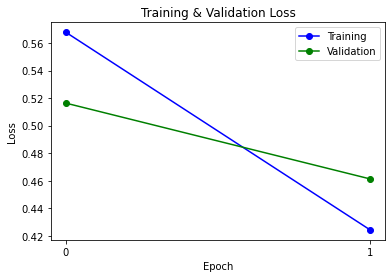

In [24]:
from matplotlib import pyplot

%matplotlib inline



pyplot.plot(df_stats['Training Loss'], 'b-o', label="Training")
pyplot.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
pyplot.title("Training & Validation Loss")
pyplot.xlabel("Epoch")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.xticks(df_stats.index.values.tolist())
pyplot.show()

# Performance On Test Set
## Data Preparation

In [25]:
test = convert_to_dataset_torch(X_test, y_test)
test_dataloader = DataLoader(test,  sampler=SequentialSampler(test), batch_size=batch_size)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1138.19it/s]


## Evaluate on Test Set
With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set:

In [26]:
bert_model.eval()

_, _,_ ,predicted_labels = eval_batch(test_dataloader, bert_model)

Evaluating: 100%|███████████████████████████████████████████████████████████████████| 32/32 [17:21<00:00, 32.55s/batch]


Let's plot confusion matix over the test results:

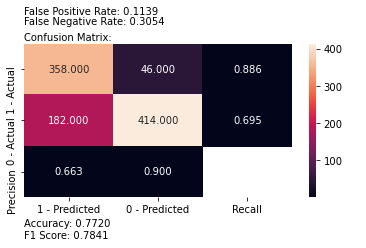

In [27]:
from ds_utils.metrics import plot_confusion_matrix



plot_confusion_matrix(y_test, predicted_labels, [1, 0])
pyplot.show()

# Saving the Fine-Tuned Model
First let's save our model with the method ``save_pretrained``, then save our tokenizer with ``save_pretrained``.

**Pay Attension**: tokenizer's ``save_pretrained`` need to get the path to save as a string.

In [28]:
from pathlib import Path



output_dir = Path("__file__").parents[0].absolute().joinpath("model_save")
output_dir.mkdir(exist_ok=True)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = bert_model.module if hasattr(bert_model, 'module') else bert_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(str(output_dir.absolute()))

('C:\\my repo\\Quora-Qusetions-Pairs-App\\training-bert\\model_save\\vocab.txt',
 'C:\\my repo\\Quora-Qusetions-Pairs-App\\training-bert\\model_save\\special_tokens_map.json',
 'C:\\my repo\\Quora-Qusetions-Pairs-App\\training-bert\\model_save\\added_tokens.json')